In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import sample
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
"""
from sklearn.model_selection import cross_val_score, KFold
from pandas import *
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import sys

In [2]:
# This is the place where your Capstone folder should be
main_path = os.getcwd()
print(main_path)

/Users/VyTran/Documents/Capstone/Capstone-Fall-2020


In [3]:
# I put my sp500.csv file inside a folder called data
symbols = pd.read_csv('./data/sp500.csv')
print(symbols.head())

   Unnamed: 0 Symbol             GICS Sector
0           0    MMM             Industrials
1           1    ABT             Health Care
2           2   ABBV             Health Care
3           3   ABMD             Health Care
4           4    ACN  Information Technology


In [4]:
import glob
import pandas as pd

# get data file names - this is for windows (you might have to change the \\ to / with Linux/Mac)
path = main_path + '/data/stock-data/'

filenames = glob.glob(path + "*.csv")
dfs = []
for filename in sorted(filenames):
    _=pd.read_csv(filename)
    _['Symbol']=filename.split('/')[-1].split('.')[0] #Maxime: I updated this part with the '\\' which is for Windows. You might have to change it back!
    _['Date'] = pd.to_datetime(_.Date)
    _ = _.sort_values(by=['Date']).reset_index(drop=True)
    dfs.append(_)

df_concat = pd.concat(dfs, ignore_index=True)
df_concat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.011942,62546300.0,A
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.786524,15234100.0,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.011942,6577800.0,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.556314,5975600.0,A
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.208586,4843200.0,A


In [5]:
# We adjust opening, high, low and close

bwd_window=50; fwd_window = 20;
#smoothing = 3 
df = df_concat.copy()
df.loc[df.Volume==0,['Open','High','Low','Close','Volume']]=np.nan

df['Open']  = df['Open'] /df['Close']*df['Adj Close']
df['High']  = df['High'] /df['Close']*df['Adj Close']
df['Low']   = df['Low']  /df['Close']*df['Adj Close']
df['Close'] = df['Close']/df['Close']*df['Adj Close']

df = df[['Date','Symbol','Open','High','Low','Close','Volume']]
df.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0
4,1999-11-24,A,24.633047,25.745754,24.556308,25.208586,4843200.0


In [6]:
for fwd_window in [5,10,20]:
    df['fwd_max_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.min().iloc[::-1].reset_index(name='field')['field']
    df['CPP'+str(fwd_window)] = 100*df['fwd_max_close']/df['Close']-100
    df['CPL'+str(fwd_window)] = 100*df['fwd_min_close']/df['Close']-100
    
    df['fwd_max_high']  = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='High', min_periods=fwd_window).High.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_low']   = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Low',  min_periods=fwd_window).Low.min().iloc[::-1].reset_index(name='field')['field']
    df['PP'+str(fwd_window)] = 100*df['fwd_max_high']/df['Open']-100
    df['PL'+str(fwd_window)] = 100*df['fwd_min_low']/df['Open']-100
    df = df.drop(columns=['fwd_max_close','fwd_min_close','fwd_max_high','fwd_min_low'])

df = df[(df.Date<'2015-01-01')&(df.Date>='1990-01-01')]
df = df[~df.isnull()]
df.head(4)

,Date,Symbol,Open,High,Low,Close,Volume,CPP5,CPL5,PP5,PL5,CPP10,CPL10,PP10,PL10,CPP20,CPL20,PP20,PL20
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0,0.000000,-9.090896,9.890120,-12.500000,0.284105,-9.090896,9.890120,-12.500000,7.386367,-9.090896,9.890120,-12.500000
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0,8.978339,-0.928768,2.474531,-7.278021,10.216735,-0.928768,6.404663,-7.278021,17.027879,-0.928768,10.043676,-7.278021
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0,0.000000,-9.090896,6.505298,-3.177014,3.977274,-9.090896,12.405443,-3.177014,7.386367,-9.090896,14.372170,-3.177014
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0,5.468737,0.000000,2.647061,-5.882379,14.374984,0.000000,9.264683,-5.882379,18.124986,0.000000,11.176457,-5.882379


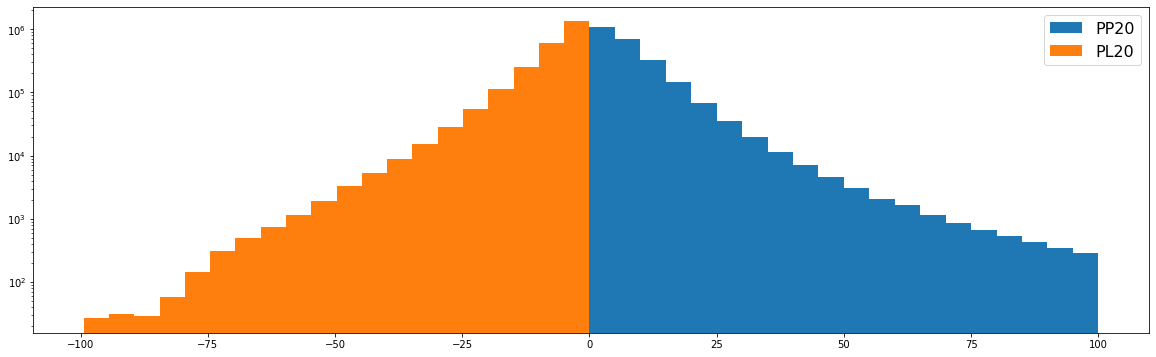

In [7]:
fs=16;
plt.figure(figsize=(20,6))
plt.hist(df.PP20[df.PP20<=100].values,20)
plt.hist(df.PL20[df.PL20<=100].values,20)
plt.yscale('log')
plt.legend(['PP20','PL20'],fontsize=fs)
plt.savefig('pp_pl_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

# symmetry of patterns

In [8]:
ind = list(df[(df['CPP20']>=10)&(df['CPP20']<=100)].index)
ind = sample(ind,len(ind))
X_data=[]; y_data=[];
s_num=50000;

for i in ind[:s_num]:
    x = df.loc[i-(bwd_window-1):i,:]['Close'].values
    s = df.loc[i-(bwd_window-1):i,:]['Symbol'].values
    y = df.loc[i-(bwd_window-1):i,:].index.values
    y = y[-1]-y[0]+1
    if np.sum(~np.isnan(x))==bwd_window and y==bwd_window and s[0]==s[-1]:
        X_data.append( (x-np.mean(x))/np.std(x) )
        y_data.append( df.loc[i,:]['CPP20'] )
        
X_data = np.array(X_data)
y_data = np.array(y_data)
print(X_data.shape, y_data.shape)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_data, y_data = shuffle(X_data, y_data, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(48844, 50) (48844,)
(39075, 50) (9769, 50) (39075,) (9769,)


## This part is some Maxime code

In [9]:
# Maxime: This part is optional, you can save the numpy arrays to avoid having to run everything each time.
with open('./data/X_train.npy', 'wb') as f:
    np.save(f, X_train)

with open('./data/X_test.npy', 'wb') as f:
    np.save(f, X_test)

In [10]:
# Maxime: This is optional too: If you have saved the numpy arrays, you can load them here

with open('./data/X_train.npy', 'rb') as f:
    X_train = np.load(f)

with open('./data/X_test.npy', 'rb') as f:
    X_test = np.load(f)

In [11]:
X_train.shape

(39075, 50)

In [12]:
X_test.shape

(9769, 50)

## Maxime's Gaussian Mixture Models

-- just an idea

In [13]:
# GMM take a while to train
from sklearn.mixture import GaussianMixture
from collections import Counter
gm = GaussianMixture(20)
gm.fit(X_train)

GaussianMixture(n_components=20)

In [14]:
# This is to see how many points there are in each cluster
y_train_pred = gm.predict(X_train)
print(y_train_pred)
print(Counter(y_train_pred)) 

[11 19  4 ...  8  6 14]
Counter({12: 3594, 3: 3239, 7: 3220, 14: 3002, 5: 2483, 2: 2305, 0: 2176, 16: 1976, 11: 1901, 8: 1815, 19: 1748, 4: 1646, 18: 1640, 13: 1541, 15: 1526, 6: 1462, 1: 1174, 10: 1170, 17: 737, 9: 720})


<Figure size 864x504 with 0 Axes>

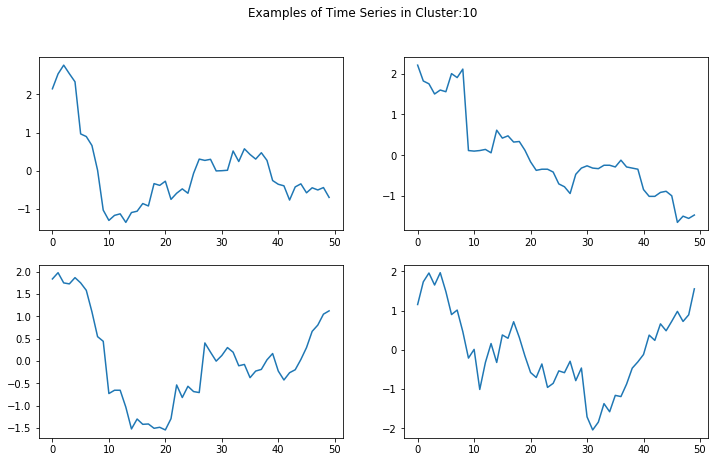

In [15]:
# We Look at the type of values that have been stored in cluster 10
cluster_nb = 10
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

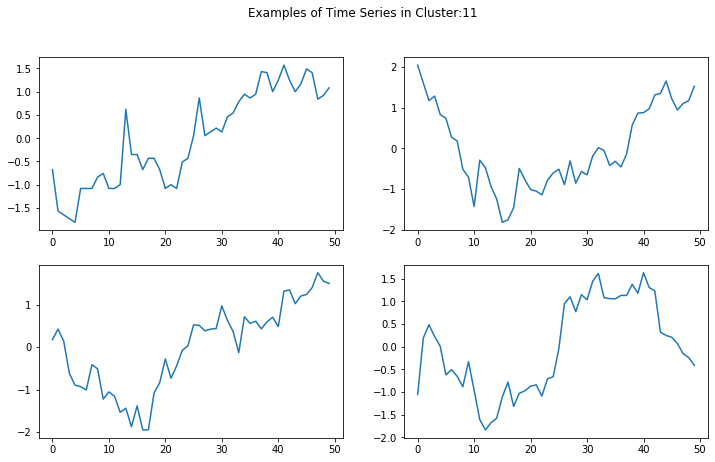

In [16]:
# We Look at the type of values that have been stored in cluster 11
cluster_nb = 11
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

<Figure size 864x504 with 0 Axes>

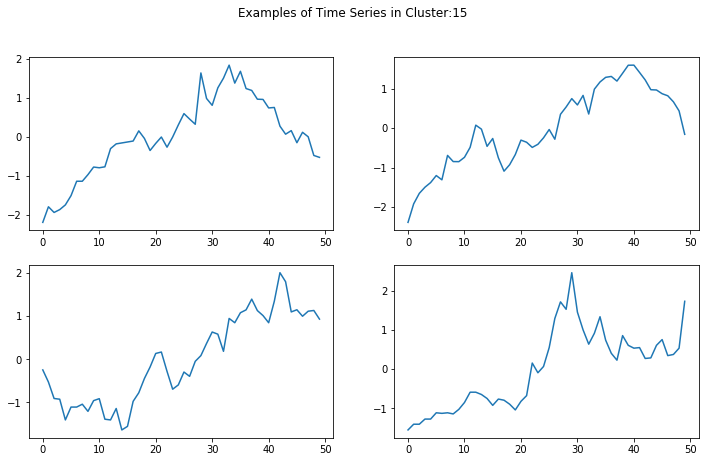

In [17]:
# We Look at the type of values that have been stored in cluster 15
cluster_nb = 15
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

# Vy's thoughts

In [55]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume,CPP5,CPL5,PP5,PL5,CPP10,CPL10,PP10,PL10,CPP20,CPL20,PP20,PL20
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0,0.000000,-9.090896,9.890120,-12.500000,0.284105,-9.090896,9.890120,-12.500000,7.386367,-9.090896,9.890120,-12.500000
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0,8.978339,-0.928768,2.474531,-7.278021,10.216735,-0.928768,6.404663,-7.278021,17.027879,-0.928768,10.043676,-7.278021
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0,0.000000,-9.090896,6.505298,-3.177014,3.977274,-9.090896,12.405443,-3.177014,7.386367,-9.090896,14.372170,-3.177014
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0,5.468737,0.000000,2.647061,-5.882379,14.374984,0.000000,9.264683,-5.882379,18.124986,0.000000,11.176457,-5.882379
4,1999-11-24,A,24.633047,25.745754,24.556308,25.208586,4843200.0,4.566219,0.000000,8.255457,-0.311530,11.415536,0.000000,15.732090,-0.311530,15.829536,0.000000,18.535834,-0.311530


### Randomly select 20000 smaller scale time series and its corresponeding multi-scale context

In [56]:
"""
Randomly pick a time point and choosing 50 days backward continuously, then put it in the smaller_matrix
Also choose 100 days backward continuously from that data point, then put it in the context_matrix
Repeat these steps 20000 times to get 2 matrices with dimension (20000, 50) and (20000, 100)
"""

import random
random.seed(40)
smaller_scale = 50
context_scale = 100
s_num=20000

smaller_matrix = np.empty(shape=[0, smaller_scale])
context_matrix = np.empty(shape=[0, context_scale])
rows = 0
while  rows < s_num:
    idx = random.randint(context_scale, df.shape[0])
    context_x = np.asarray(df.loc[idx-(context_scale-1):idx,:].loc[:, 'Close'].values).reshape(1,-1)
    smaller_x = np.asarray(df.loc[idx-(smaller_scale-1):idx,:].loc[:, 'Close'].values).reshape(1,-1)
    if context_x.shape[1] == context_scale and smaller_x.shape[1] == smaller_scale and np.sum(~np.isnan(context_x))==context_scale and np.sum(~np.isnan(smaller_x))==smaller_scale:
        # Adjusted Close price
        context_matrix = np.append(context_matrix, 
                                   (context_x-np.mean(context_x))/np.std(context_x), 
                                   axis = 0)
        smaller_matrix = np.append(smaller_matrix, 
                                   (smaller_x-np.mean(smaller_x))/np.std(smaller_x),
                                   axis = 0)
        rows += 1
    else:
        continue

In [57]:
smaller_matrix.shape

(20000, 50)

In [58]:
context_matrix.shape

(20000, 100)

In [59]:
# Each row is a time series of length 50 days
smaller_matrix

array([[-1.66542228, -1.27554348, -1.34211387, ..., -1.33557561,
        -1.54508007, -0.8689488 ],
       [-1.31913473, -1.16988752, -1.39830041, ...,  1.01764529,
         0.84857843,  0.98690789],
       [ 0.24466821, -0.11073876, -0.01596129, ..., -1.49171085,
        -1.6118003 , -1.15544098],
       ...,
       [-0.72877121, -0.72877121, -0.62433839, ..., -0.05114927,
         0.48826224,  0.59613843],
       [-1.50347122, -1.88186916, -1.61931692, ...,  0.62969289,
         0.38100279,  0.66077808],
       [ 1.24701529,  1.24701529,  1.18572265, ..., -0.39613333,
        -0.52009958, -0.45811466]])

In [60]:
# Each row is a time series of length 100 days
context_matrix

array([[ 0.3974329 , -0.04909139, -0.32624141, ..., -1.37069544,
        -1.5405609 , -0.99235608],
       [-0.24033835, -0.49475451, -0.43626862, ...,  1.59398546,
         1.46148311,  1.56989572],
       [-0.21490402, -0.34461641, -0.53918647, ..., -2.07260348,
        -2.23696894, -1.61235362],
       ...,
       [-2.49811976, -2.21540452, -1.64999619, ...,  0.42753405,
         0.92999574,  1.03048238],
       [ 2.29531798,  1.96675578,  1.6792618 , ...,  1.01713794,
         0.82692067,  1.04091427],
       [-0.2269538 ,  0.13353155,  0.20562777, ..., -0.57348894,
        -0.7192929 , -0.6463888 ]])

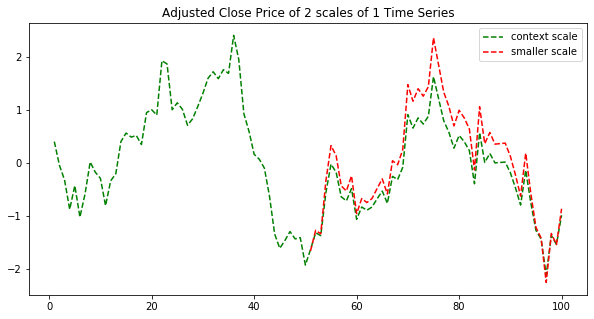

In [61]:
# Plot the first row of context_matrix (aka multiscale matrix) and first row in smaller_matrix
# The 2 line should match but because we standardize the values so they differ a bit
fig,ax = plt.subplots(figsize=(10,5))
x = np.arange(1, context_scale + 1)  
y = context_matrix[0,:]
plt.plot(x, y, color ="green", linestyle='dashed', label='context scale');
x1 = np.arange(context_scale - smaller_scale + 1, context_scale + 1)  
y1 = smaller_matrix[0,:]
plt.plot(x1, y1, color ="red", linestyle='dashed', label='smaller scale');
plt.legend();
plt.title("Adjusted Close Price of 2 scales of 1 Time Series");

In [62]:
from statsmodels.multivariate.pca import PCA

In [63]:
"""
Initiate PCA, which will do dimension reduction on the context_matrix,
which will bring the dimension from 100 columns down to 50 columns
Then get the embedding matrix of the context_matrix and call it context_embedding
"""
pca = PCA(context_matrix, ncomp = smaller_scale, standardize = True, demean = False, normalize = False, method = 'nipals')
# Scores is the embedding matrix
context_embedding = pca.scores

In [64]:
def compare_embedding_smaller(time_series_idx):
    """
    Comparison between the smaller scale time series (right) and its corresponding row in the embedding matrix (left)
    """
    fig,ax = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Comparison between embedding of context and its smaller scale of time series '+str(time_series_idx), fontsize = 15, x = 0.1)
    x = np.arange(1, smaller_scale + 1)  
    y = context_embedding[time_series_idx,:]
    ax[0].plot(x, y, color ="green", linestyle='dashed', label='embedding context scale');
    ax[0].legend();
    ax[0].set(title = "Embedding of 1 time series");
    x1 = np.arange(1, smaller_scale + 1)  
    y1 = smaller_matrix[time_series_idx,:]
    ax[1].plot(x1, y1, color ="red", linestyle='dashed', label='smaller scale');
    ax[1].legend();
    ax[1].set(title = "Smaller scale time series");

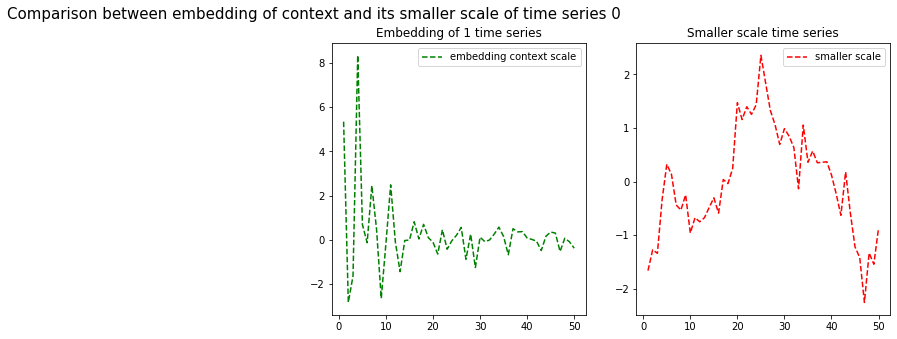

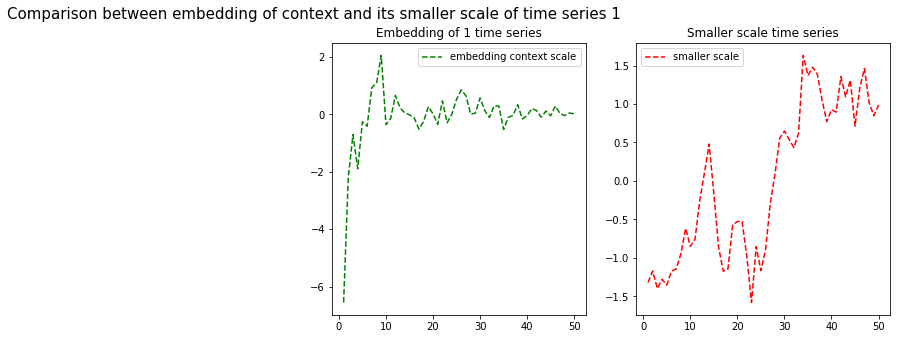

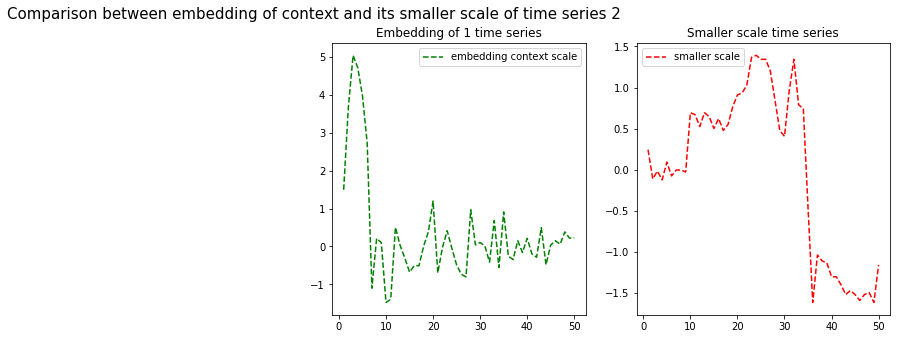

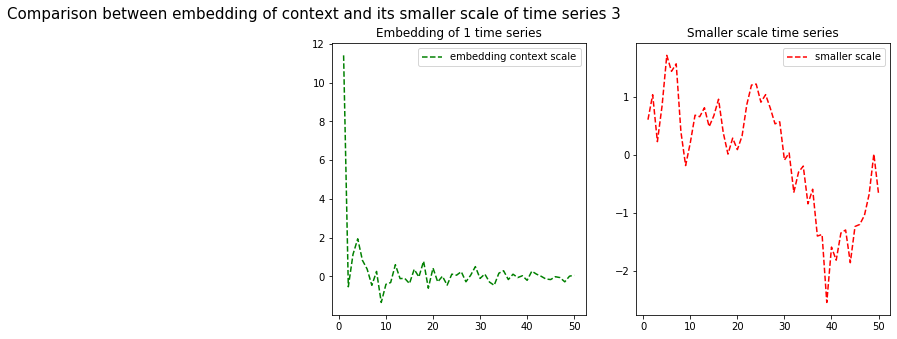

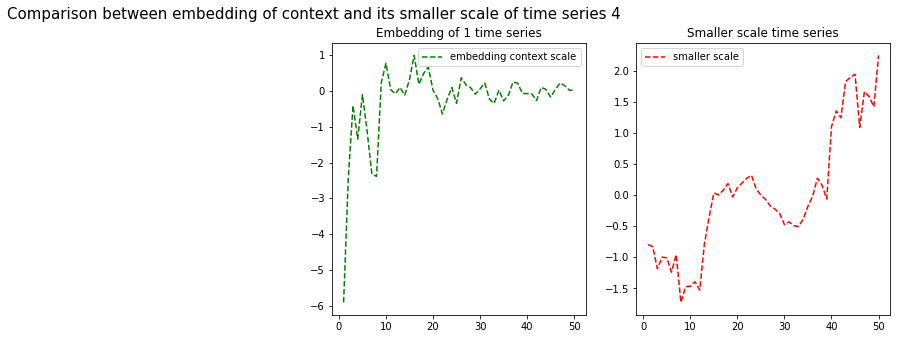

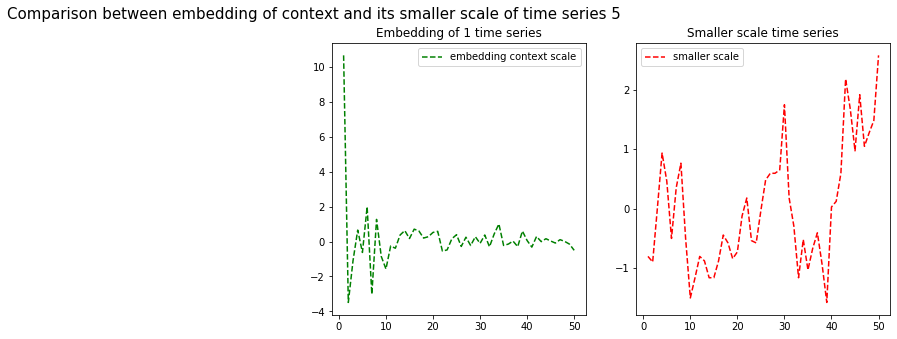

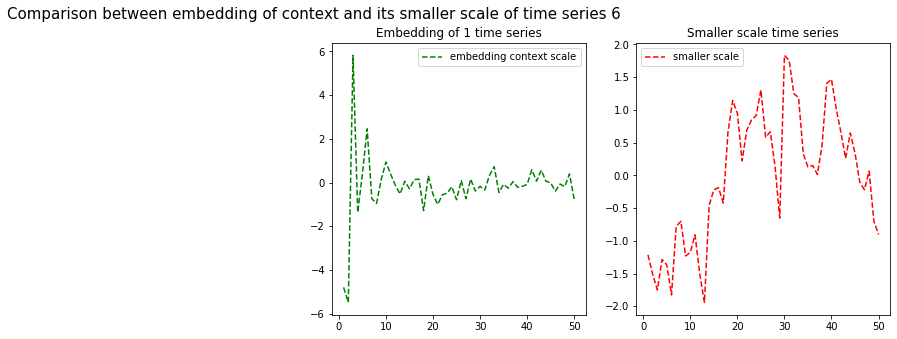

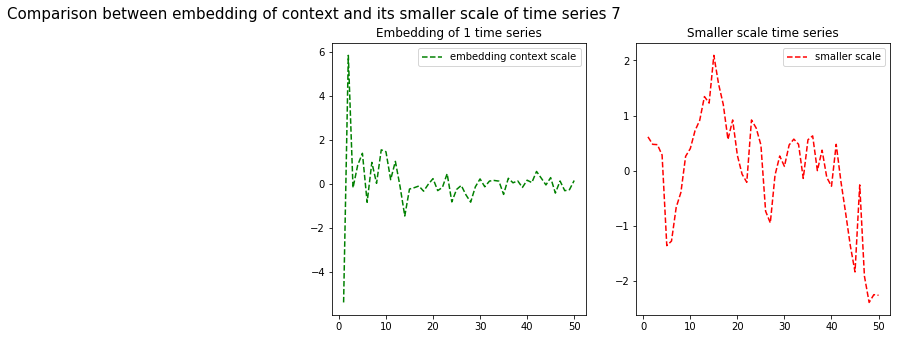

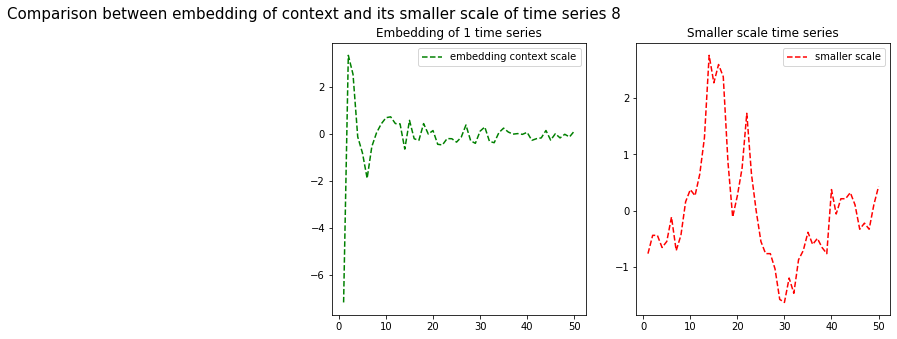

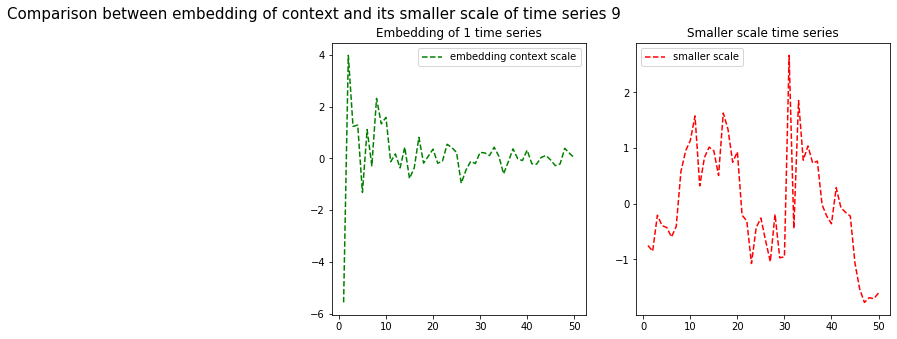

In [65]:
# plot the comparisons for the first 10 time series
for i in range(10):
    compare_embedding_smaller(i)

In [66]:
# Combine the embedding matrix and the smaller_matrix
X_train = np.append(context_embedding, smaller_matrix, axis = 1)

In [67]:
# Print first row of the X_train matrix, 
# [0:50] is the embedding and [51:100] is the smaller scale context
X_train[0]

array([ 5.34895785, -2.84203025, -1.64191771,  8.35194051,  0.68295338,
       -0.13515502,  2.44889604,  0.47461136, -2.65885457, -0.1521815 ,
        2.48449101, -0.10605635, -1.44613436, -0.0357205 , -0.01415443,
        0.8132591 ,  0.03357719,  0.69654245,  0.09415234, -0.11289837,
       -0.64917484,  0.45350498, -0.43128103, -0.04752701,  0.20384852,
        0.55704936, -0.88688348,  0.25252499, -1.26068891,  0.11381526,
       -0.08496409, -0.01559593,  0.25178747,  0.56983183,  0.14615396,
       -0.68034853,  0.4997966 ,  0.35418731,  0.36639393,  0.07916313,
        0.01322779, -0.06579707, -0.48960646,  0.15706708,  0.34764627,
        0.30125566, -0.53083229,  0.06352827, -0.09464257, -0.38329663,
       -1.66542228, -1.27554348, -1.34211387, -0.34366439,  0.32195485,
        0.13177637, -0.43876123, -0.53384938, -0.24858058, -0.96175692,
       -0.67647509, -0.75255864, -0.67647509, -0.48630748, -0.30563999,
       -0.59090227,  0.03668822, -0.03938013,  0.24588215,  1.47

### K_means clustering with 10 clusters

In [68]:
# K-means clustering with 10 clusters
from sklearn.cluster import KMeans, SpectralClustering
km = KMeans(n_clusters=10, random_state=0)
km.fit(X_train)
print(km.cluster_centers_.shape)
print(km.labels_.shape)

(10, 100)
(20000,)


In [69]:
y_train_pred = km.predict(X_train)
print(y_train_pred)
print(Counter(y_train_pred))

[2 0 3 ... 4 9 1]
Counter({0: 4232, 9: 2264, 5: 2114, 6: 1945, 3: 1822, 8: 1678, 1: 1649, 7: 1545, 2: 1458, 4: 1293})


<Figure size 864x504 with 0 Axes>

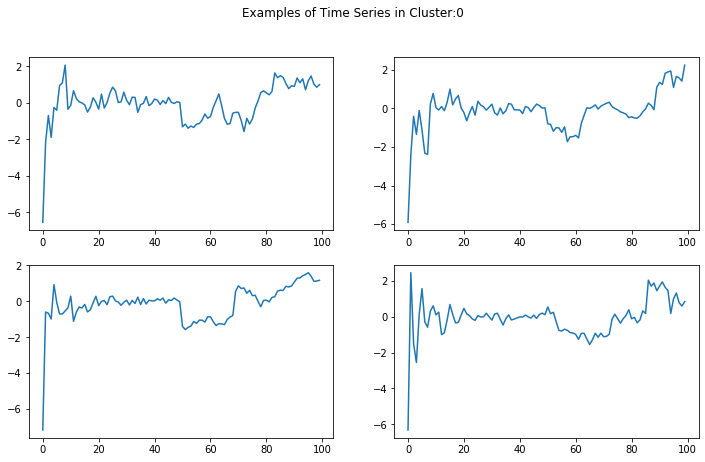

In [70]:
# We Look at the type of values that have been stored in cluster 0
cluster_nb = 0
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

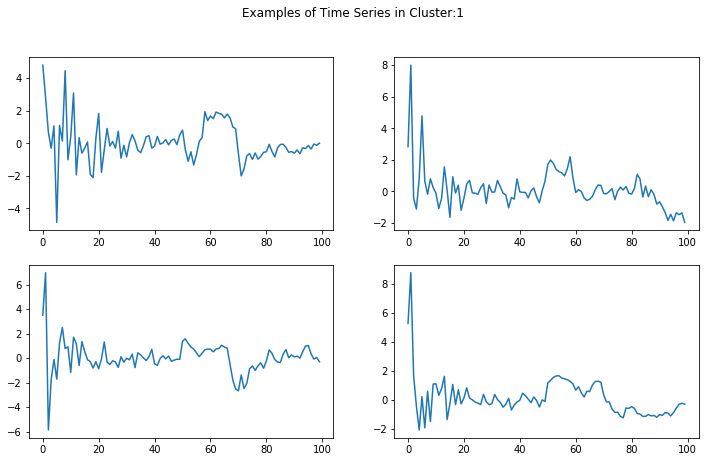

In [71]:
# We Look at the type of values that have been stored in cluster 1
cluster_nb = 1
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

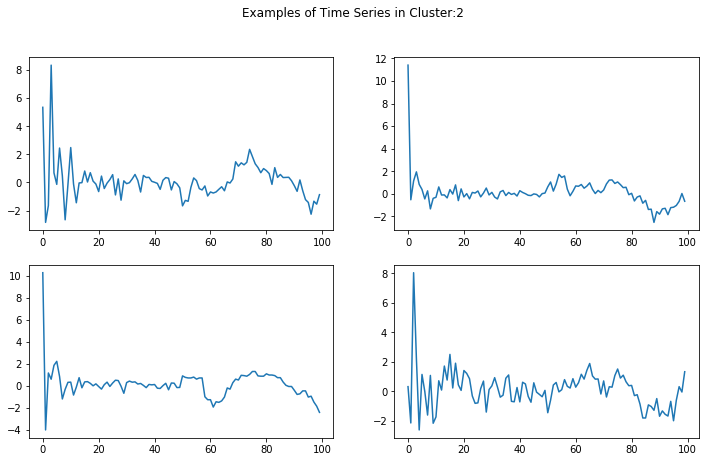

In [72]:
# We Look at the type of values that have been stored in cluster 2
cluster_nb = 2
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

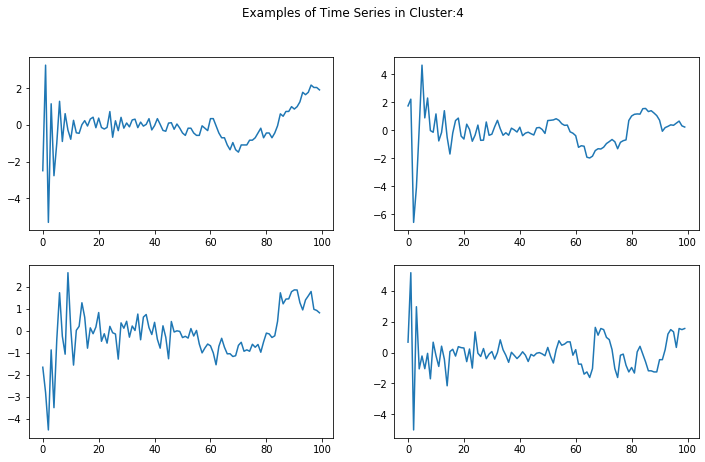

In [73]:
# We Look at the type of values that have been stored in cluster 4
cluster_nb = 4
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

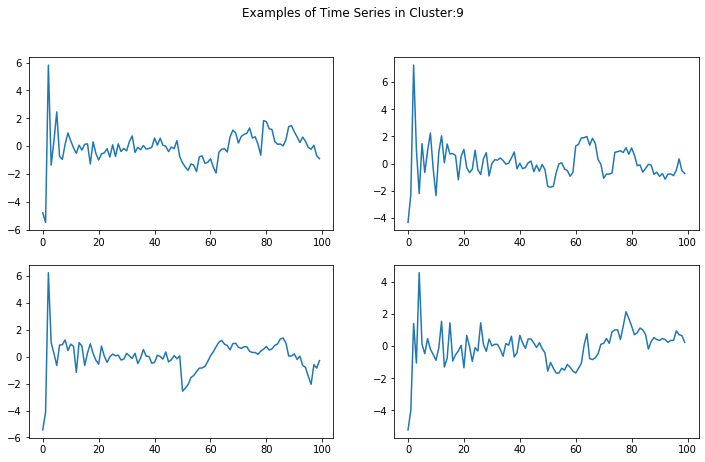

In [74]:
# We Look at the type of values that have been stored in cluster 9
cluster_nb = 9
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

### GMM clustering with 20 clusters

In [75]:
from sklearn.mixture import GaussianMixture
from collections import Counter
gm = GaussianMixture(20)
gm.fit(X_train)

GaussianMixture(n_components=20)

In [76]:
# This is to see how many points there are in each cluster
y_train_pred = gm.predict(X_train)
print(y_train_pred)
print(Counter(y_train_pred)) 

[16 16  9 ...  4  7  9]
Counter({9: 1827, 5: 1799, 8: 1707, 2: 1626, 7: 1586, 4: 1584, 16: 1444, 15: 1249, 10: 1203, 13: 1017, 0: 946, 1: 908, 11: 870, 3: 807, 18: 670, 19: 302, 14: 135, 17: 123, 12: 101, 6: 96})


<Figure size 864x504 with 0 Axes>

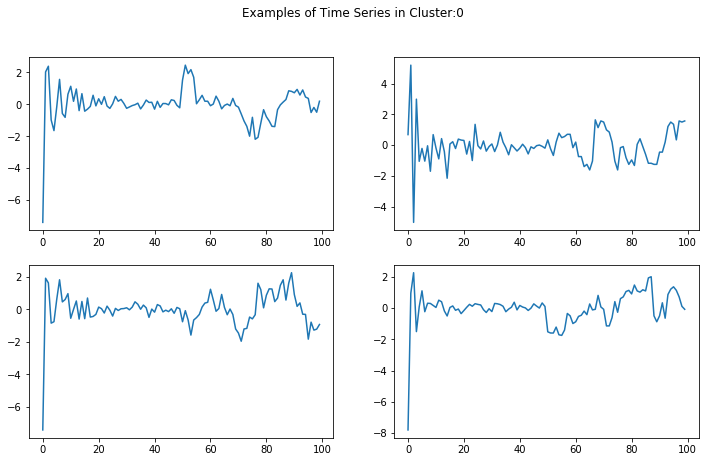

In [77]:
# We Look at the type of values that have been stored in cluster 10
cluster_nb = 0
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

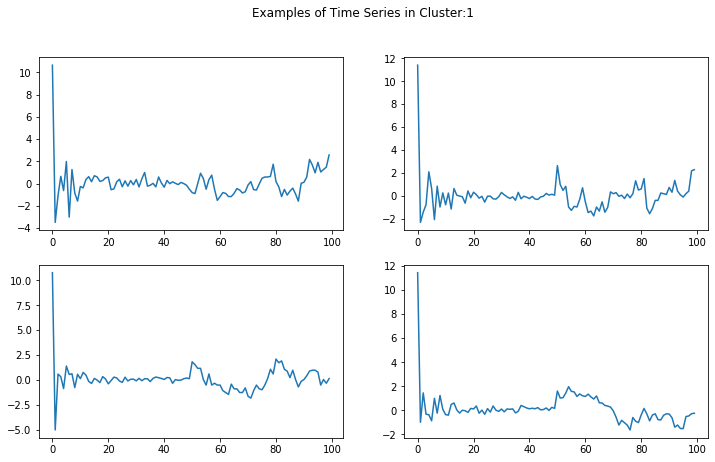

In [78]:
cluster_nb = 1
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

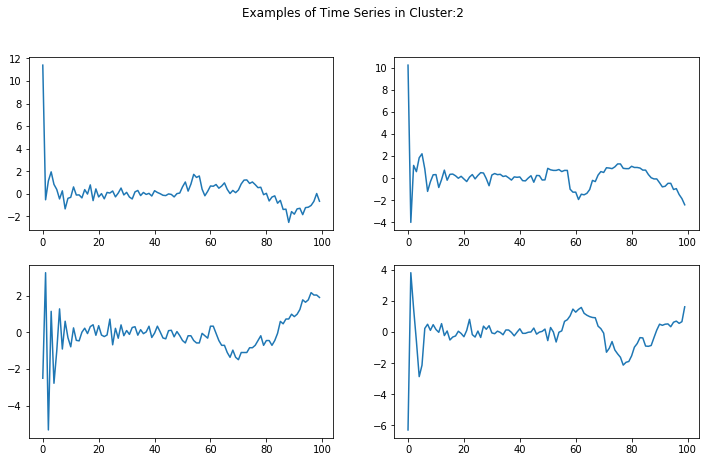

In [79]:
cluster_nb = 2
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

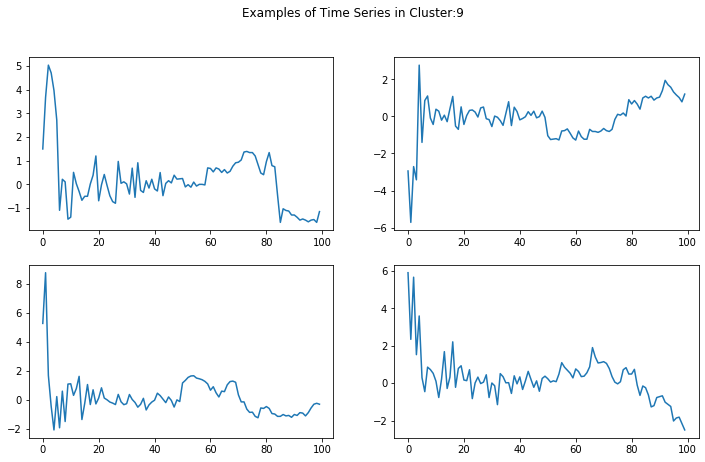

In [80]:
cluster_nb = 9
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

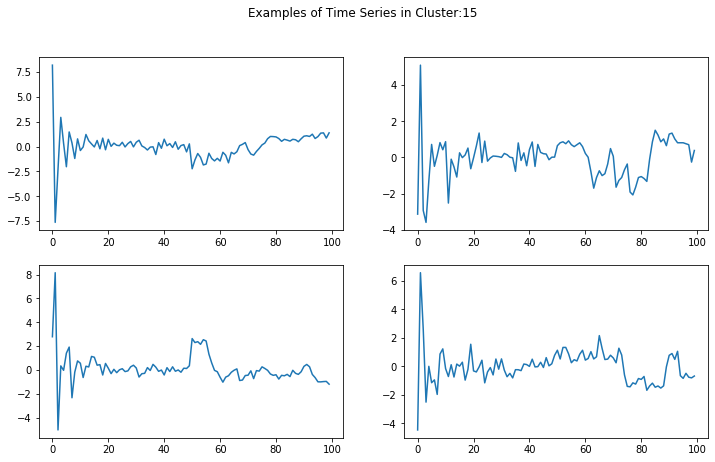

In [81]:
cluster_nb = 15
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

## This is Naftali's clustering

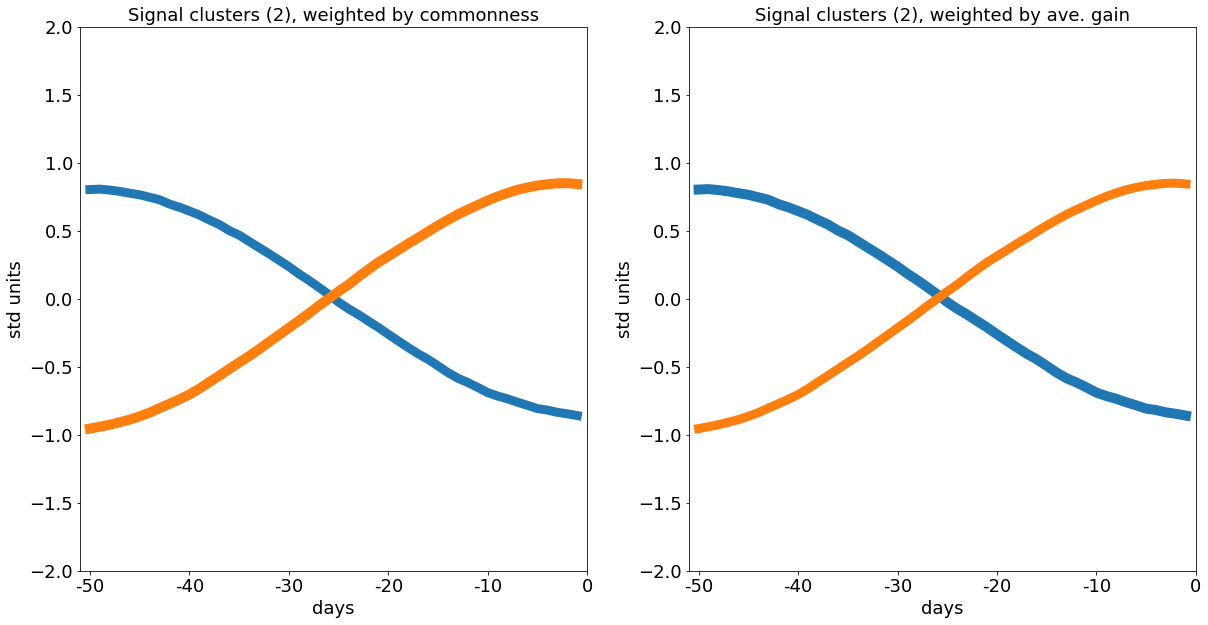

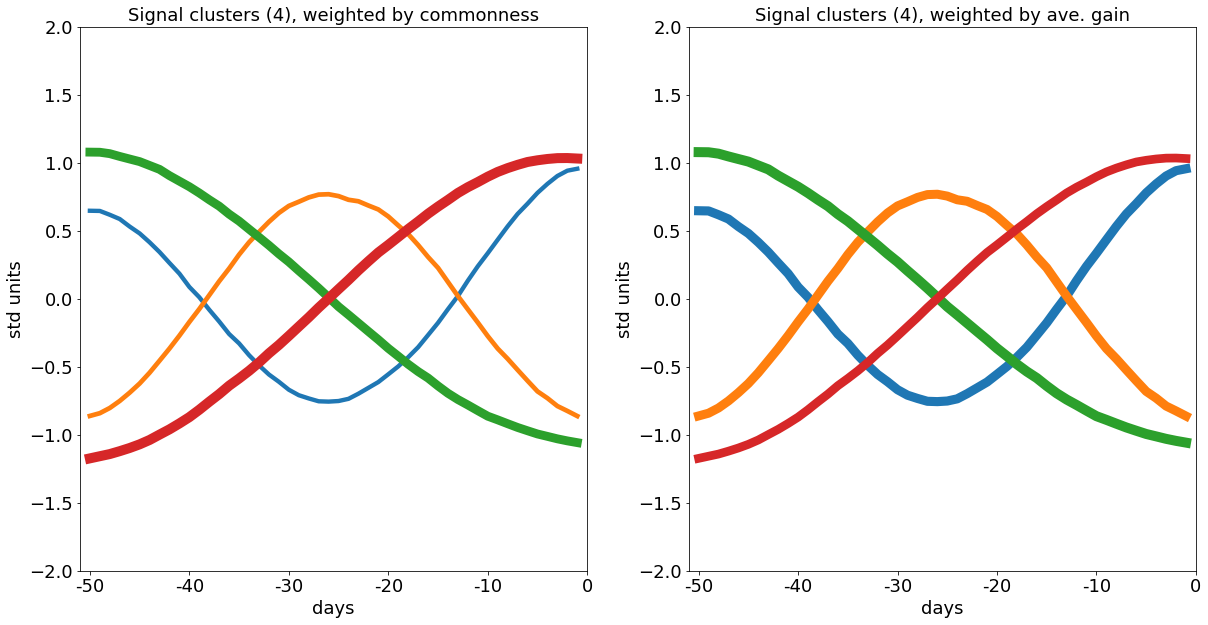

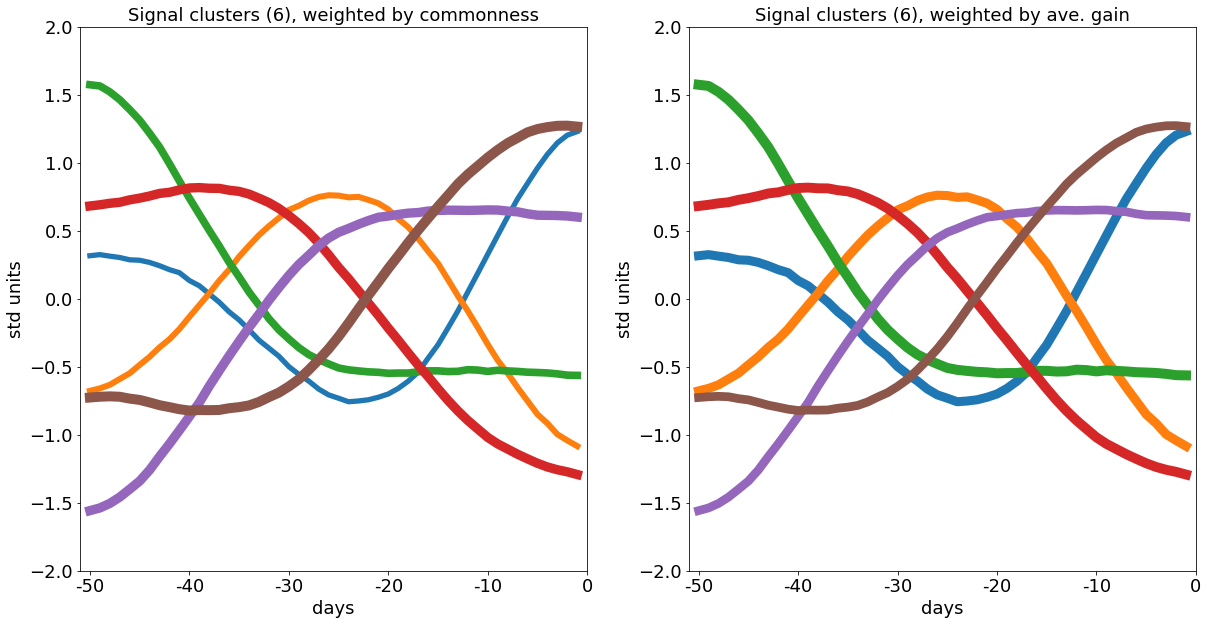

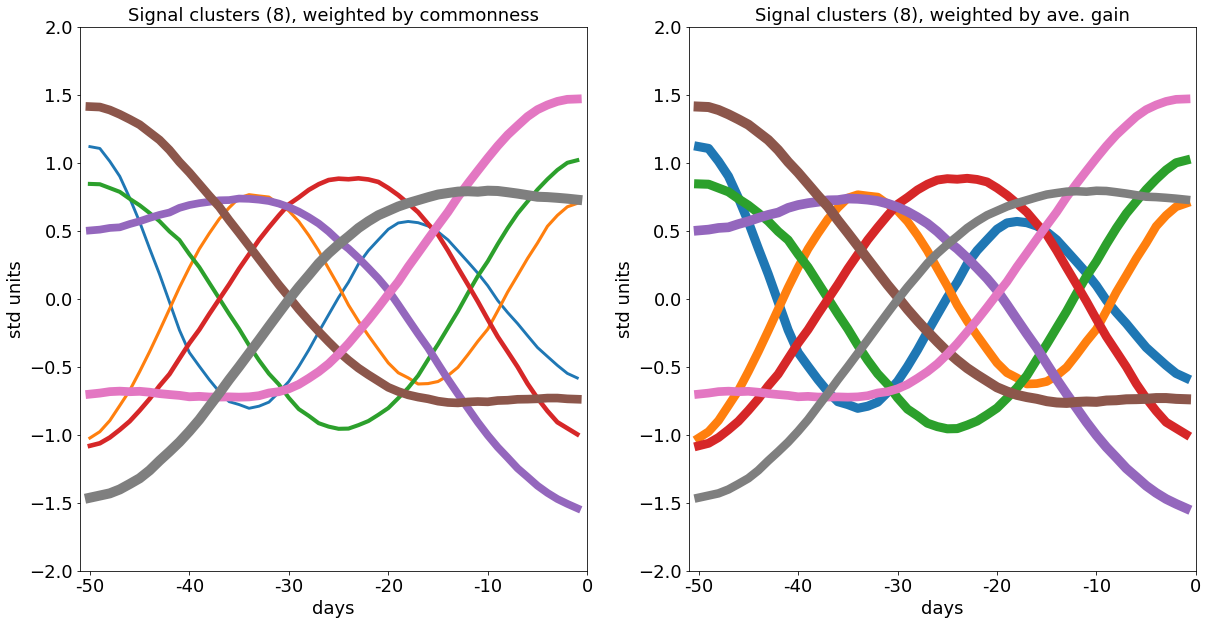

In [84]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans, SpectralClustering
cl=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
cl=['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636'][::-1]
#https://colorbrewer2.org/#type=sequential&scheme=PuRd&n=9

for n_clusters in [2,4,6,8]:
    clu = KMeans(n_clusters=n_clusters,random_state=0)

    clu.fit( X_data ); labels1 = clu.labels_

    fs=18;
    c=[]
    plt.figure(figsize=(20,10));
    plt.subplot(121)
    w1=[]
    for i in range(n_clusters):
        w1.append( len(X_data[labels1==i])/len(X_data) )
    fact=10/max(w1)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w1[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by commonness',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.subplot(122)
    w2=[]
    for i in range(n_clusters):
        w2.append( np.mean(y_data[labels1==i]) )
    fact=10/max(w2)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w2[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by ave. gain',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.savefig('cpp_'+str(n_clusters)+'_clustered_buy_signals.png',dpi=100,bbox_inches='tight',pad_inches=.05)
    plt.show()

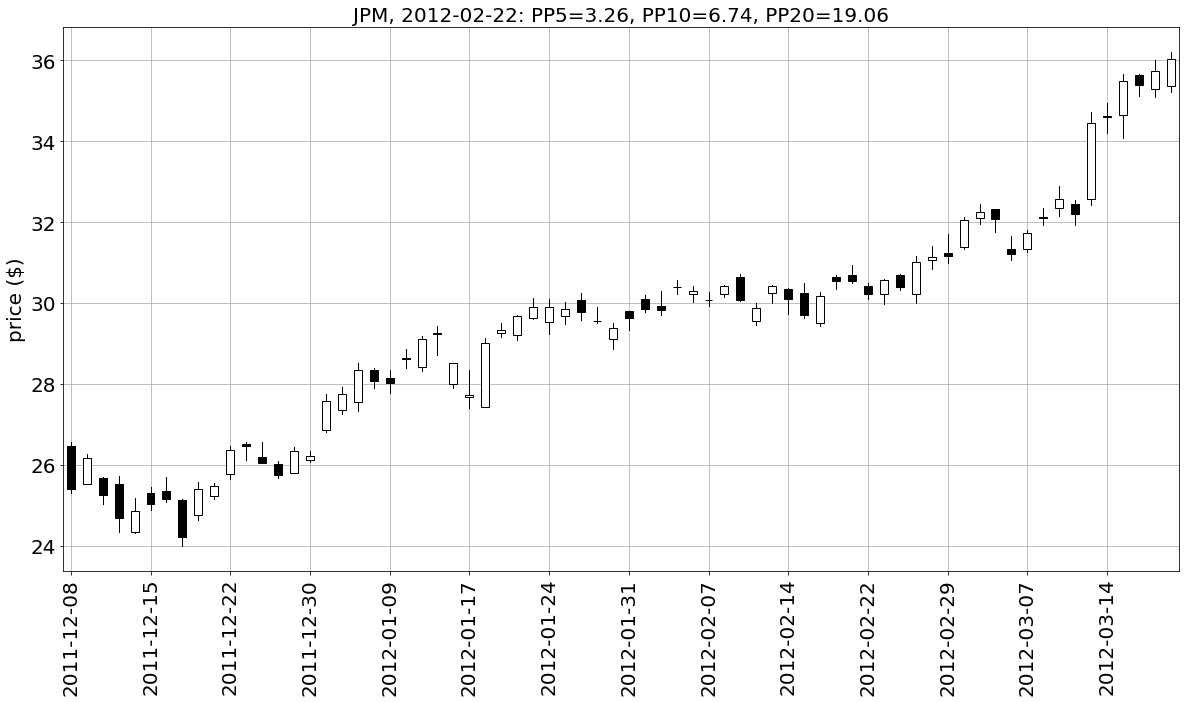

In [85]:
sym = 'JPM'
ind=list(df.loc[(df.loc[:,'Symbol']==sym) & (df.loc[:,'PP20']>10) & (df.loc[:,'Date']>'2010-01-01'),:].index.values)
ind=sample(ind,1)[0]
#ind=1178830
bwd_window=50; fwd_window = 20;
fs=20
a=df.loc[ind-bwd_window:ind+fwd_window-1,:][['Date','Open','Open','Open','High','Low','Close','Close','Close']].reset_index(drop=True)
a.Date=a.Date.astype(str)
data=np.array(a)[:,1:].T
#data=(data-np.min(np.min(data)))/(np.max(np.max(data))-np.min(np.min(data)))
xlabels=np.array(a)[:,0]
plt.figure(figsize=(20,10))
#plt.subplot(3,3,i+1)
bplot=plt.boxplot(data,showfliers=False,showcaps=False,whis='range',medianprops={'linewidth': 0},patch_artist=True,labels=xlabels)
colors=['white' if data[0,i]<data[7,i] else 'black' for i in range(data.shape[1]) ]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
#rr=round(df.loc[ind,'RR-5'],2),round(df.loc[ind,'RR-10'],2),round(df.loc[ind,'RR-20'],2)
pp=round(df.loc[ind,'PP5'],2),round(df.loc[ind,'PP10'],2),round(df.loc[ind,'PP20'],2)
d=str(df.loc[ind,'Date']).split(' ')[0]
#ratio=round(len(z_data[y>y_threshold,0][labels==i])/len(z_data[y>y_threshold,0]),2)
title=sym+', '+d+': PP5='+str(pp[0])+', PP10='+str(pp[1])+', PP20='+str(pp[2])
plt.title(title,fontsize=fs)
plt.ylabel('price ($)',fontsize=fs)
plt.xticks(range(1,len(xlabels)+1)[::5],xlabels[::5],fontsize=fs)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs)
plt.xticks(rotation=90)
plt.grid('on')
plt.savefig('pp_example.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


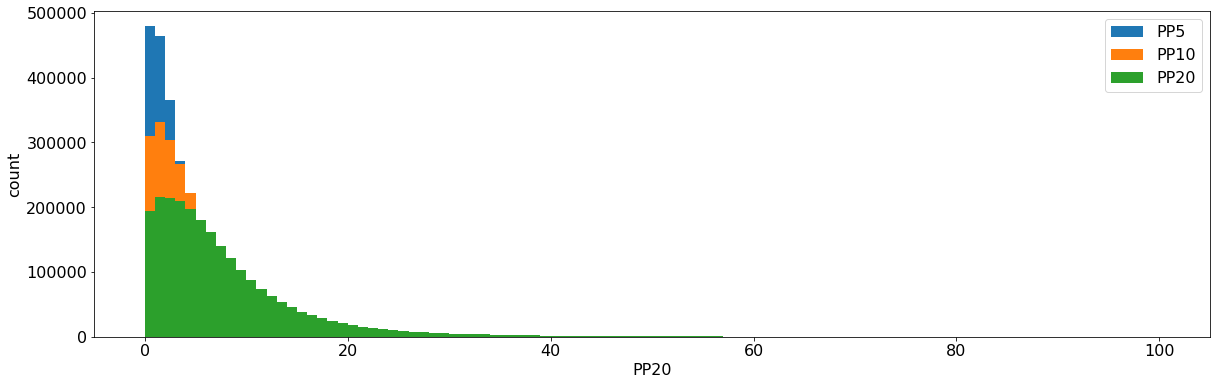

In [86]:
fs=16
plt.figure(figsize=(20,6))

x = df['PP5'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP10'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP20'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs);
plt.xlabel('PP20',fontsize=fs)
plt.ylabel('count',fontsize=fs)
plt.legend(['PP5','PP10','PP20'],fontsize=fs)
plt.savefig('pp_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()